In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1:],'GPU')
#tf.executing_eagerly()
print(tf.executing_eagerly())

print(tf.__version__)


True
2.6.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 

for gpu_instance in physical_devices:
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
fraction = 50
reduction = 1/2
stride1 = 1
stride2 = 1
stride3 = 13
strides = stride1*stride2*stride3

datasetNo = 4

num_param = 10
num_time = 800
num_time_to = 780
num_node = int(14300/fraction)
#num_node = 14300
num_var = 1

n_epochs = 100000               # epoch to call
n_epochs_latent=200
batch_size = 1
LR = 1e-7
Lv1_latent_dim = int(128*8)
C1 = int(64*2/reduction)
C2 = int(128*2/reduction)
C3 = int(256*2/reduction)
print(Lv1_latent_dim)

alpha = 0

1024


In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[1,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 286, 8000)
8000


In [11]:
# validate
data.shape

(1, 286, 8000)

In [12]:
x_axis = np.linspace(0,num_node,num_node)

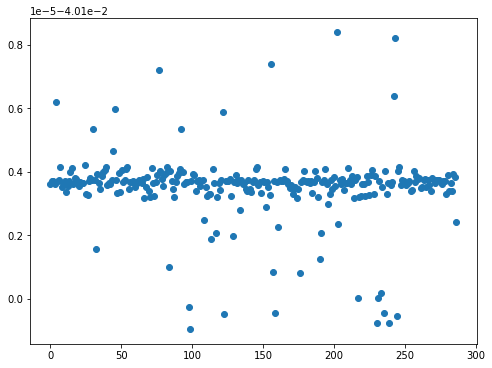

In [13]:
plt.scatter(x_axis, data[0,:,0])

## FOM data type : FOM_data = np.array[param, time, node, var]

In [14]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data_temp = FOM_data
del FOM_data

FOM_data = np.zeros((num_param, num_time_to, num_node, num_var))
for i in range(num_time_to):
    FOM_data[:,i,:,:] = FOM_data_temp[:,i,:,:]

del FOM_data_temp
num_time_to = num_time
    
FOM_data.shape

#del data

(10, 780, 286, 1)

In [15]:
x_axis = np.linspace(0,num_node,num_node)

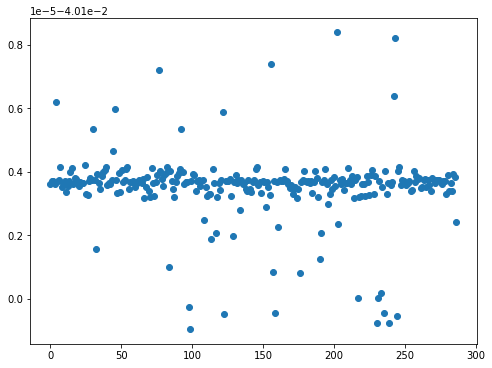

In [16]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [17]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0400963761125
-0.0489409761125
-0.0413117761125
-0.040096287525


In [18]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [19]:
print(maximum)
print(minimum)
print(mean)
print(AT)

0.143542529125
-0.1364653525
0.0006077139113373788
0.280007881625


In [20]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
FOM_data = FOM_data-np.min(FOM_data)

In [21]:
print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [22]:
FOM_data.shape

(10, 780, 286, 1)

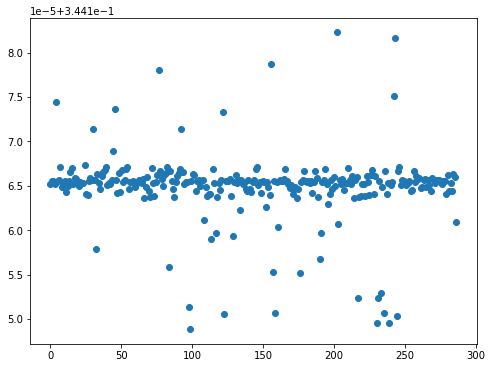

In [23]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

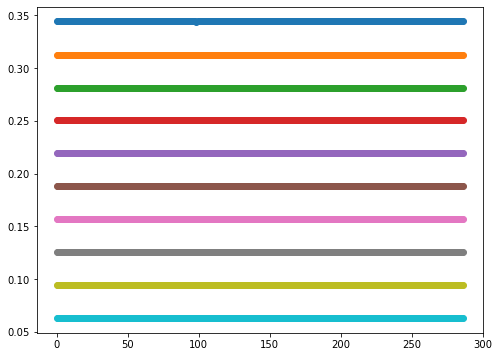

In [24]:

for i in range(num_param):
    plt.scatter(x_axis, FOM_data[i,0,:,0])

# Level 1, SVAE (spatial VAE)

In [25]:
Lv1_input = np.zeros((num_param,num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data#.reshape(-1, num_node, num_var)
    
Lv1_input.shape
del FOM_data
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

In [26]:
#validate

Lv1_input[9,0,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [27]:
Lv1_input_shape = Lv1_input.shape[1:]

In [28]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(10, 780, 286, 1)
(780, 286, 1)


# Encoder

In [29]:

def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv2D(C3, 5, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(x_input)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv2D(C2, 5, strides=stride2, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv2D(C1, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    ################################################################################################0
    #x=layers.Conv2D(1, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    #x=layers.LeakyReLU(0.2)(x)
    #x=layers.Dropout(0.3)(x)
    ################################################################################################0
    
    x=layers.Flatten()(x)
    
    mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [mu, var, z], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 780, 286, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 22, 1024) 26624       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 22, 1024) 4096        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 60, 22, 1024) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Decoder

In [30]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)
print(Lv1_input_shape)
print(Lv1_input.shape[0])
print(int(Lv1_input.shape[1]/4)*int(Lv1_input.shape[2]/4)*Lv1_latent_dim)

1024
780
(780, 286, 1)
10
14177280


In [31]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(int(Lv1_input.shape[1]/strides)*int(Lv1_input.shape[2]/strides)*num_var, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([int(Lv1_input.shape[1]/strides),int(Lv1_input.shape[2]/strides), num_var])(z)
    
    z=layers.Conv2DTranspose(C3, 4, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv2DTranspose(C2, 4, strides=stride2, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv2DTranspose(C1, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [mu_prime, var_prime], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1320)         1353000     input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 1320)         0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 60, 22, 1)    0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

# loss computation

In [32]:
def compute_loss(mu, var, mu_prime, var_prime, real_img, beta):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum((0.5*tf.math.log(var_prime) + tf.math.square(real_img - mu_prime)/(2*var_prime)), 1))
    
    KL_divergence = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((tf.math.square(mu) + var - tf.math.log(var) - 1), 1))
    
    VAE_loss = reconstruction_error + beta * KL_divergence # L(X0)+L(X1)+L(X2)
    
    mu_a = mu[1:num_param-1,:]
    mu_b = (mu[0:num_param-2,:]+mu[2:num_param,:])/2
    var_a = var[1:num_param-1,:]
    var_b = (var[0:num_param-2,:]+var[2:num_param,:])/4

    loss_constraint = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((var_a/var_b + tf.math.square(mu_b - mu_a)/var_b - 1 + tf.math.log(var_b/var_a)),1))
    
    loss = VAE_loss + alpha * loss_constraint
    
    return loss

# VAE

In [33]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            mu, var, latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            mu_prime, var_prime = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(mu, var, mu_prime, var_prime, real_img, beta)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [34]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained/decoder_COPY_%d.h5' % (epoch+1)
                filename2 = 'test_constrained/encoder_COPY_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [35]:
Lv1_input.shape
print(type(Lv1_input))

<class 'numpy.ndarray'>


# Warm up

In [36]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [37]:
Lv1_input.shape

(10, 780, 286, 1)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=compute_loss)

start = time.time()
#vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1])
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/100000
10/10 [==============================] - 285s 80ms/step - loss: 780404.0376
Epoch 2/100000
10/10 [==============================] - 1s 78ms/step - loss: 455783.8260
Epoch 3/100000
10/10 [==============================] - 1s 79ms/step - loss: 1134826.1435
Epoch 4/100000
10/10 [==============================] - 1s 79ms/step - loss: 1022439.8200
Epoch 5/100000
10/10 [==============================] - 1s 79ms/step - loss: 1140048.2962
Epoch 6/100000
10/10 [==============================] - 1s 79ms/step - loss: 548693.5692
Epoch 7/100000
10/10 [==============================] - 1s 78ms/step - loss: 3846912.3409
Epoch 8/100000
10/10 [==============================] - 1s 78ms/step - loss: 577316.3008
Epoch 9/100000
10/10 [==============================] - 1s 78ms/step - loss: 648037.2741
Epoch 10/100000
10/10 [==============================] - 1s 78ms/step - loss: 631585.9535
Epoch 11/100000
10/10 [==============================] - 1s 78ms/step - loss: 381375.5959
Epoch 12/1000

10/10 [==============================] - 1s 78ms/step - loss: 172344.7287
Epoch 90/100000
10/10 [==============================] - 1s 78ms/step - loss: 837707.5071
Epoch 91/100000
10/10 [==============================] - 1s 79ms/step - loss: 222874.2908
Epoch 92/100000
10/10 [==============================] - 1s 78ms/step - loss: 302046.6619
Epoch 93/100000
10/10 [==============================] - 1s 78ms/step - loss: 687382.3913
Epoch 94/100000
10/10 [==============================] - 1s 78ms/step - loss: 152600.9354
Epoch 95/100000
10/10 [==============================] - 1s 79ms/step - loss: 447804.7841
Epoch 96/100000
10/10 [==============================] - 1s 78ms/step - loss: 337963.9737
Epoch 97/100000
10/10 [==============================] - 1s 78ms/step - loss: 398922.6669
Epoch 98/100000
10/10 [==============================] - 1s 78ms/step - loss: 151932.9109
Epoch 99/100000
10/10 [==============================] - 1s 78ms/step - loss: 317423.2081
Epoch 100/100000
10/10 [==

10/10 [==============================] - 1s 79ms/step - loss: 1566481.4641
Epoch 180/100000
10/10 [==============================] - 1s 79ms/step - loss: 215311.8018
Epoch 181/100000
10/10 [==============================] - 1s 79ms/step - loss: 138132.1580
Epoch 182/100000
10/10 [==============================] - 1s 78ms/step - loss: 169125.1371
Epoch 183/100000
10/10 [==============================] - 1s 78ms/step - loss: 140275.4265
Epoch 184/100000
10/10 [==============================] - 1s 78ms/step - loss: 291948.0962
Epoch 185/100000
10/10 [==============================] - 1s 78ms/step - loss: 155364.4361
Epoch 186/100000
10/10 [==============================] - 1s 78ms/step - loss: 343366.4528
Epoch 187/100000
10/10 [==============================] - 1s 79ms/step - loss: 143886.4652
Epoch 188/100000
10/10 [==============================] - 1s 79ms/step - loss: 3927092.8065
Epoch 189/100000
10/10 [==============================] - 1s 78ms/step - loss: 1428480.2660
Epoch 190/100

10/10 [==============================] - 1s 79ms/step - loss: 110664.4371
Epoch 270/100000
10/10 [==============================] - 1s 79ms/step - loss: 109998.9382
Epoch 271/100000
10/10 [==============================] - 1s 79ms/step - loss: 113584.1200
Epoch 272/100000
10/10 [==============================] - 1s 79ms/step - loss: 1203515.0046
Epoch 273/100000
10/10 [==============================] - 1s 79ms/step - loss: 269093.6275
Epoch 274/100000
10/10 [==============================] - 1s 79ms/step - loss: 262642.5771
Epoch 275/100000
10/10 [==============================] - 1s 79ms/step - loss: 102487.7479
Epoch 276/100000
10/10 [==============================] - 1s 79ms/step - loss: 116097.5463
Epoch 277/100000
10/10 [==============================] - 1s 79ms/step - loss: 74562.6935
Epoch 278/100000
10/10 [==============================] - 1s 79ms/step - loss: 210990.1321
Epoch 279/100000
10/10 [==============================] - 1s 79ms/step - loss: 140367.4776
Epoch 280/100000

10/10 [==============================] - 1s 79ms/step - loss: 162362.4391
Epoch 360/100000
10/10 [==============================] - 1s 79ms/step - loss: 158280.0151
Epoch 361/100000
10/10 [==============================] - 1s 79ms/step - loss: 79808.6335
Epoch 362/100000
10/10 [==============================] - 1s 79ms/step - loss: 53178.9386
Epoch 363/100000
10/10 [==============================] - 1s 79ms/step - loss: 123206.1009
Epoch 364/100000
10/10 [==============================] - 1s 79ms/step - loss: 514462.6452
Epoch 365/100000
10/10 [==============================] - 1s 79ms/step - loss: 73525.4790
Epoch 366/100000
10/10 [==============================] - 1s 79ms/step - loss: 313047.8775
Epoch 367/100000
10/10 [==============================] - 1s 79ms/step - loss: 138160.0153
Epoch 368/100000
10/10 [==============================] - 1s 79ms/step - loss: 750268.9181
Epoch 369/100000
10/10 [==============================] - 1s 79ms/step - loss: 487618.4624
Epoch 370/100000
10

10/10 [==============================] - 1s 79ms/step - loss: 119719.9979
Epoch 450/100000
10/10 [==============================] - 1s 79ms/step - loss: 88881.8878
Epoch 451/100000
10/10 [==============================] - 1s 79ms/step - loss: 124743.4386
Epoch 452/100000
10/10 [==============================] - 1s 79ms/step - loss: 119969.8237
Epoch 453/100000
10/10 [==============================] - 1s 79ms/step - loss: 79070.2136
Epoch 454/100000
10/10 [==============================] - 1s 79ms/step - loss: 105606.6195
Epoch 455/100000
10/10 [==============================] - 1s 79ms/step - loss: 157135.4588
Epoch 456/100000
10/10 [==============================] - 1s 79ms/step - loss: 143085.4727
Epoch 457/100000
10/10 [==============================] - 1s 79ms/step - loss: 632404.5938
Epoch 458/100000
10/10 [==============================] - 1s 79ms/step - loss: 105008.7401
Epoch 459/100000
10/10 [==============================] - 1s 79ms/step - loss: 51570.9911
Epoch 460/100000
10

10/10 [==============================] - 1s 79ms/step - loss: 364678.2463
Epoch 540/100000
10/10 [==============================] - 1s 79ms/step - loss: 88894.4799
Epoch 541/100000
10/10 [==============================] - 1s 79ms/step - loss: 110955.2965
Epoch 542/100000
10/10 [==============================] - 1s 79ms/step - loss: 140142.4689
Epoch 543/100000
10/10 [==============================] - 1s 79ms/step - loss: 137283.9828
Epoch 544/100000
10/10 [==============================] - 1s 79ms/step - loss: 77163.0570
Epoch 545/100000
10/10 [==============================] - 1s 79ms/step - loss: 81649.2434
Epoch 546/100000
10/10 [==============================] - 1s 79ms/step - loss: 107047.6907
Epoch 547/100000
10/10 [==============================] - 1s 79ms/step - loss: 48498.6116
Epoch 548/100000
10/10 [==============================] - 1s 79ms/step - loss: 62150.1223
Epoch 549/100000
10/10 [==============================] - 1s 79ms/step - loss: 81082.2855
Epoch 550/100000
10/10

10/10 [==============================] - 1s 80ms/step - loss: 77609.0417
Epoch 630/100000
10/10 [==============================] - 1s 80ms/step - loss: 53494.2493
Epoch 631/100000
10/10 [==============================] - 1s 80ms/step - loss: 46851.4513
Epoch 632/100000
10/10 [==============================] - 1s 80ms/step - loss: 47722.6683
Epoch 633/100000
10/10 [==============================] - 1s 80ms/step - loss: 40869.9160
Epoch 634/100000
10/10 [==============================] - 1s 79ms/step - loss: 62901.1355
Epoch 635/100000
10/10 [==============================] - 1s 80ms/step - loss: 44202.7881
Epoch 636/100000
10/10 [==============================] - 1s 80ms/step - loss: 251626.8393
Epoch 637/100000
10/10 [==============================] - 1s 79ms/step - loss: 88690.6274
Epoch 638/100000
10/10 [==============================] - 1s 80ms/step - loss: 558601.0877
Epoch 639/100000
10/10 [==============================] - 1s 79ms/step - loss: 42581.1697
Epoch 640/100000
10/10 [=

10/10 [==============================] - 1s 79ms/step - loss: 72089.7276
Epoch 721/100000
10/10 [==============================] - 1s 79ms/step - loss: 124141.4974
Epoch 722/100000
10/10 [==============================] - 1s 79ms/step - loss: 220372.6504
Epoch 723/100000
10/10 [==============================] - 1s 79ms/step - loss: 35041.6578
Epoch 724/100000
10/10 [==============================] - 1s 79ms/step - loss: 49030.2296
Epoch 725/100000
10/10 [==============================] - 1s 79ms/step - loss: 39783.4802
Epoch 726/100000
10/10 [==============================] - 1s 79ms/step - loss: 62603.8580
Epoch 727/100000
10/10 [==============================] - 1s 79ms/step - loss: 32026.5176
Epoch 728/100000
10/10 [==============================] - 1s 79ms/step - loss: 39199.5424
Epoch 729/100000
10/10 [==============================] - 1s 79ms/step - loss: 76143.9523
Epoch 730/100000
10/10 [==============================] - 1s 79ms/step - loss: 333662.1440
Epoch 731/100000
10/10 [

10/10 [==============================] - 1s 79ms/step - loss: 34630.6221
Epoch 812/100000
10/10 [==============================] - 1s 79ms/step - loss: 55117.6336
Epoch 813/100000
10/10 [==============================] - 1s 79ms/step - loss: 41333.7930
Epoch 814/100000
10/10 [==============================] - 1s 79ms/step - loss: 169751.4874
Epoch 815/100000
10/10 [==============================] - 1s 79ms/step - loss: 23120.3959
Epoch 816/100000
10/10 [==============================] - 1s 79ms/step - loss: 70084.6302
Epoch 817/100000
10/10 [==============================] - 1s 79ms/step - loss: 26290.1290
Epoch 818/100000
10/10 [==============================] - 1s 79ms/step - loss: 26124.1305
Epoch 819/100000
10/10 [==============================] - 1s 79ms/step - loss: 66941.1932
Epoch 820/100000
10/10 [==============================] - 1s 80ms/step - loss: 27609.0507
Epoch 821/100000
10/10 [==============================] - 1s 80ms/step - loss: 30827.4482
Epoch 822/100000
10/10 [==

10/10 [==============================] - 1s 80ms/step - loss: 45114.2541
Epoch 903/100000
10/10 [==============================] - 1s 80ms/step - loss: 20781.2245
Epoch 904/100000
10/10 [==============================] - 1s 81ms/step - loss: 26435.3710
Epoch 905/100000
10/10 [==============================] - 1s 80ms/step - loss: 22946.9157
Epoch 906/100000
10/10 [==============================] - 1s 80ms/step - loss: 31616.4857
Epoch 907/100000
10/10 [==============================] - 1s 80ms/step - loss: 88114.0815
Epoch 908/100000
10/10 [==============================] - 1s 80ms/step - loss: 20122.4342
Epoch 909/100000
10/10 [==============================] - 1s 79ms/step - loss: 24577.0033
Epoch 910/100000
10/10 [==============================] - 1s 79ms/step - loss: 39274.6901
Epoch 911/100000
10/10 [==============================] - 1s 79ms/step - loss: 23669.3940
Epoch 912/100000
10/10 [==============================] - 1s 80ms/step - loss: 19217.8580
Epoch 913/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: 18808.1745
Epoch 994/100000
10/10 [==============================] - 1s 79ms/step - loss: 19793.2831
Epoch 995/100000
10/10 [==============================] - 1s 79ms/step - loss: 13028.8134
Epoch 996/100000
10/10 [==============================] - 1s 79ms/step - loss: 26708.7836
Epoch 997/100000
10/10 [==============================] - 1s 79ms/step - loss: 16298.7436
Epoch 998/100000
10/10 [==============================] - 1s 79ms/step - loss: 21560.6385
Epoch 999/100000
10/10 [==============================] - 1s 79ms/step - loss: 17906.8661
Epoch 1000/100000
10/10 [==============================] - 1s 79ms/step - loss: 24579.1441
Epoch 1001/100000
10/10 [==============================] - 1s 79ms/step - loss: 17371.8829
Epoch 1002/100000
10/10 [==============================] - 1s 79ms/step - loss: 19413.0665
Epoch 1003/100000
10/10 [==============================] - 1s 79ms/step - loss: 24454.9576
Epoch 1004/100000
10/10

10/10 [==============================] - 1s 80ms/step - loss: 22842.5934
Epoch 1080/100000
10/10 [==============================] - 1s 80ms/step - loss: 14190.7179
Epoch 1081/100000
10/10 [==============================] - 1s 79ms/step - loss: 13949.5000
Epoch 1082/100000
10/10 [==============================] - 1s 79ms/step - loss: 31747.9336
Epoch 1083/100000
10/10 [==============================] - 1s 79ms/step - loss: 19431.6995
Epoch 1084/100000
10/10 [==============================] - 1s 79ms/step - loss: 18812.9210
Epoch 1085/100000
10/10 [==============================] - 1s 79ms/step - loss: 27360.4389
Epoch 1086/100000
10/10 [==============================] - 1s 79ms/step - loss: 25286.3330
Epoch 1087/100000
10/10 [==============================] - 1s 79ms/step - loss: 27455.3435
Epoch 1088/100000
10/10 [==============================] - 1s 79ms/step - loss: 11730.9992
Epoch 1089/100000
10/10 [==============================] - 1s 79ms/step - loss: 14721.3167
Epoch 1090/100000

10/10 [==============================] - 1s 79ms/step - loss: 23045.6355
Epoch 1170/100000
10/10 [==============================] - 1s 79ms/step - loss: 8770.5819
Epoch 1171/100000
10/10 [==============================] - 1s 79ms/step - loss: 13177.3983
Epoch 1172/100000
10/10 [==============================] - 1s 79ms/step - loss: 10447.7440
Epoch 1173/100000
10/10 [==============================] - 1s 79ms/step - loss: 35221.3476
Epoch 1174/100000
10/10 [==============================] - 1s 79ms/step - loss: 14172.6162
Epoch 1175/100000
10/10 [==============================] - 1s 79ms/step - loss: 16954.7668
Epoch 1176/100000
10/10 [==============================] - 1s 79ms/step - loss: 13869.4012
Epoch 1177/100000
10/10 [==============================] - 1s 79ms/step - loss: 14233.9413
Epoch 1178/100000
10/10 [==============================] - 1s 79ms/step - loss: 9561.3550
Epoch 1179/100000
10/10 [==============================] - 1s 79ms/step - loss: 14753.0206
Epoch 1180/100000
1

10/10 [==============================] - 1s 79ms/step - loss: 13755.3303
Epoch 1260/100000
10/10 [==============================] - 1s 79ms/step - loss: 56568.0091
Epoch 1261/100000
10/10 [==============================] - 1s 79ms/step - loss: 11075.6501
Epoch 1262/100000
10/10 [==============================] - 1s 79ms/step - loss: 8135.2619
Epoch 1263/100000
10/10 [==============================] - 1s 79ms/step - loss: 8356.9392
Epoch 1264/100000
10/10 [==============================] - 1s 79ms/step - loss: 15819.1087
Epoch 1265/100000
10/10 [==============================] - 1s 79ms/step - loss: 151656.9568
Epoch 1266/100000
10/10 [==============================] - 1s 79ms/step - loss: 7102.1698
Epoch 1267/100000
10/10 [==============================] - 1s 79ms/step - loss: 15116.0522
Epoch 1268/100000
10/10 [==============================] - 1s 79ms/step - loss: 9990.8797
Epoch 1269/100000
10/10 [==============================] - 1s 79ms/step - loss: 34403.1946
Epoch 1270/100000
10

10/10 [==============================] - 1s 79ms/step - loss: 11887.0068
Epoch 1350/100000
10/10 [==============================] - 1s 80ms/step - loss: 6316.4614
Epoch 1351/100000
10/10 [==============================] - 1s 79ms/step - loss: 10755.4674
Epoch 1352/100000
10/10 [==============================] - 1s 80ms/step - loss: 10507.0593
Epoch 1353/100000
10/10 [==============================] - 1s 79ms/step - loss: 5419.9945
Epoch 1354/100000
10/10 [==============================] - 1s 80ms/step - loss: 6857.8986
Epoch 1355/100000
10/10 [==============================] - 1s 79ms/step - loss: 7277.3297
Epoch 1356/100000
10/10 [==============================] - 1s 79ms/step - loss: 14632.3121
Epoch 1357/100000
10/10 [==============================] - 1s 80ms/step - loss: 24550.0887
Epoch 1358/100000
10/10 [==============================] - 1s 80ms/step - loss: 7431.1398
Epoch 1359/100000
10/10 [==============================] - 1s 79ms/step - loss: 8197.1521
Epoch 1360/100000
10/10

10/10 [==============================] - 1s 79ms/step - loss: 7173.0460
Epoch 1441/100000
10/10 [==============================] - 1s 79ms/step - loss: 6425.7944
Epoch 1442/100000
10/10 [==============================] - 1s 79ms/step - loss: 4742.1799
Epoch 1443/100000
10/10 [==============================] - 1s 79ms/step - loss: 10294.7196
Epoch 1444/100000
10/10 [==============================] - 1s 79ms/step - loss: 6231.7170
Epoch 1445/100000
10/10 [==============================] - 1s 79ms/step - loss: 6542.6935
Epoch 1446/100000
10/10 [==============================] - 1s 80ms/step - loss: 5756.1021
Epoch 1447/100000
10/10 [==============================] - 1s 79ms/step - loss: 6053.6421
Epoch 1448/100000
10/10 [==============================] - 1s 79ms/step - loss: 5309.2084
Epoch 1449/100000
10/10 [==============================] - 1s 79ms/step - loss: 5907.8219
Epoch 1450/100000
10/10 [==============================] - 1s 79ms/step - loss: 8353.6363
Epoch 1451/100000
10/10 [==

10/10 [==============================] - 1s 79ms/step - loss: 4941.8423
Epoch 1532/100000
10/10 [==============================] - 1s 79ms/step - loss: 8389.0153
Epoch 1533/100000
10/10 [==============================] - 1s 80ms/step - loss: 4014.6308
Epoch 1534/100000
10/10 [==============================] - 1s 79ms/step - loss: 5478.3889
Epoch 1535/100000
10/10 [==============================] - 1s 79ms/step - loss: 4102.3815
Epoch 1536/100000
10/10 [==============================] - 1s 79ms/step - loss: 3598.5151
Epoch 1537/100000
10/10 [==============================] - 1s 79ms/step - loss: 4721.9417
Epoch 1538/100000
10/10 [==============================] - 1s 79ms/step - loss: 5388.8747
Epoch 1539/100000
10/10 [==============================] - 1s 79ms/step - loss: 10541.3822
Epoch 1540/100000
10/10 [==============================] - 1s 79ms/step - loss: 6567.9633
Epoch 1541/100000
10/10 [==============================] - 1s 79ms/step - loss: 5325.7063
Epoch 1542/100000
10/10 [==

10/10 [==============================] - 1s 79ms/step - loss: 3221.3257
Epoch 1623/100000
10/10 [==============================] - 1s 80ms/step - loss: 5581.3823
Epoch 1624/100000
10/10 [==============================] - 1s 79ms/step - loss: 2528.0281
Epoch 1625/100000
10/10 [==============================] - 1s 79ms/step - loss: 3296.4193
Epoch 1626/100000
10/10 [==============================] - 1s 79ms/step - loss: 4416.1083
Epoch 1627/100000
10/10 [==============================] - 1s 80ms/step - loss: 2392.0801
Epoch 1628/100000
10/10 [==============================] - 1s 79ms/step - loss: 3141.4045
Epoch 1629/100000
10/10 [==============================] - 1s 79ms/step - loss: 3116.5495
Epoch 1630/100000
10/10 [==============================] - 1s 80ms/step - loss: 2913.2334
Epoch 1631/100000
10/10 [==============================] - 1s 79ms/step - loss: 3211.1292
Epoch 1632/100000
10/10 [==============================] - 1s 79ms/step - loss: 2623.7463
Epoch 1633/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: 2613.6955
Epoch 1714/100000
10/10 [==============================] - 1s 79ms/step - loss: 2963.4315
Epoch 1715/100000
10/10 [==============================] - 1s 79ms/step - loss: 3132.9253
Epoch 1716/100000
10/10 [==============================] - 1s 79ms/step - loss: 2360.3335
Epoch 1717/100000
10/10 [==============================] - 1s 79ms/step - loss: 3297.1108
Epoch 1718/100000
10/10 [==============================] - 1s 79ms/step - loss: 2438.8237
Epoch 1719/100000
10/10 [==============================] - 1s 79ms/step - loss: 3499.7912
Epoch 1720/100000
10/10 [==============================] - 1s 79ms/step - loss: 2289.7564
Epoch 1721/100000
10/10 [==============================] - 1s 79ms/step - loss: 2674.2361
Epoch 1722/100000
10/10 [==============================] - 1s 79ms/step - loss: 2986.3837
Epoch 1723/100000
10/10 [==============================] - 1s 79ms/step - loss: 2745.7265
Epoch 1724/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: 1699.3602
Epoch 1805/100000
10/10 [==============================] - 1s 79ms/step - loss: 1535.0043
Epoch 1806/100000
10/10 [==============================] - 1s 79ms/step - loss: 1964.3552
Epoch 1807/100000
10/10 [==============================] - 1s 79ms/step - loss: 2757.6263
Epoch 1808/100000
10/10 [==============================] - 1s 79ms/step - loss: 1715.6907
Epoch 1809/100000
10/10 [==============================] - 1s 79ms/step - loss: 1764.0423
Epoch 1810/100000
10/10 [==============================] - 1s 79ms/step - loss: 1776.3131
Epoch 1811/100000
10/10 [==============================] - 1s 79ms/step - loss: 1797.1423
Epoch 1812/100000
10/10 [==============================] - 1s 79ms/step - loss: 2090.2241
Epoch 1813/100000
10/10 [==============================] - 1s 79ms/step - loss: 2176.5736
Epoch 1814/100000
10/10 [==============================] - 1s 79ms/step - loss: 3606.5717
Epoch 1815/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: 1101.6563
Epoch 1896/100000
10/10 [==============================] - 1s 79ms/step - loss: 1229.5946
Epoch 1897/100000
10/10 [==============================] - 1s 79ms/step - loss: 1538.9549
Epoch 1898/100000
10/10 [==============================] - 1s 78ms/step - loss: 1206.7524
Epoch 1899/100000
10/10 [==============================] - 1s 80ms/step - loss: 1471.9585
Epoch 1900/100000
10/10 [==============================] - 1s 79ms/step - loss: 1197.2417
Epoch 1901/100000
10/10 [==============================] - 1s 79ms/step - loss: 1660.3935
Epoch 1902/100000
10/10 [==============================] - 1s 79ms/step - loss: 1676.6707
Epoch 1903/100000
10/10 [==============================] - 1s 79ms/step - loss: 1344.0909
Epoch 1904/100000
10/10 [==============================] - 1s 79ms/step - loss: 1464.7194
Epoch 1905/100000
10/10 [==============================] - 1s 79ms/step - loss: 1269.4971
Epoch 1906/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: 1035.4658
Epoch 1987/100000
10/10 [==============================] - 1s 79ms/step - loss: 1088.2093
Epoch 1988/100000
10/10 [==============================] - 1s 79ms/step - loss: 1100.7692
Epoch 1989/100000
10/10 [==============================] - 1s 79ms/step - loss: 1033.9963
Epoch 1990/100000
10/10 [==============================] - 1s 80ms/step - loss: 1296.6321
Epoch 1991/100000
10/10 [==============================] - 1s 79ms/step - loss: 1084.8314
Epoch 1992/100000
10/10 [==============================] - 1s 79ms/step - loss: 889.3181
Epoch 1993/100000
10/10 [==============================] - 1s 80ms/step - loss: 1013.6877
Epoch 1994/100000
10/10 [==============================] - 1s 79ms/step - loss: 1147.3505
Epoch 1995/100000
10/10 [==============================] - 1s 79ms/step - loss: 848.3886
Epoch 1996/100000
10/10 [==============================] - 1s 79ms/step - loss: 965.8964
Epoch 1997/100000
10/10 [======

10/10 [==============================] - 1s 79ms/step - loss: 893.2310
Epoch 2075/100000
10/10 [==============================] - 1s 79ms/step - loss: 628.7036
Epoch 2076/100000
10/10 [==============================] - 1s 79ms/step - loss: 608.6873
Epoch 2077/100000
10/10 [==============================] - 1s 79ms/step - loss: 876.5573
Epoch 2078/100000
10/10 [==============================] - 1s 79ms/step - loss: 1435.8248
Epoch 2079/100000
10/10 [==============================] - 1s 79ms/step - loss: 733.1268
Epoch 2080/100000
10/10 [==============================] - 1s 79ms/step - loss: 715.2494
Epoch 2081/100000
10/10 [==============================] - 1s 79ms/step - loss: 632.2311
Epoch 2082/100000
10/10 [==============================] - 1s 79ms/step - loss: 943.2583
Epoch 2083/100000
10/10 [==============================] - 1s 79ms/step - loss: 742.8184
Epoch 2084/100000
10/10 [==============================] - 1s 79ms/step - loss: 643.1533
Epoch 2085/100000
10/10 [=============

10/10 [==============================] - 1s 79ms/step - loss: 454.0732
Epoch 2167/100000
10/10 [==============================] - 1s 79ms/step - loss: 539.5266
Epoch 2168/100000
10/10 [==============================] - 1s 79ms/step - loss: 448.0629
Epoch 2169/100000
10/10 [==============================] - 1s 79ms/step - loss: 452.3948
Epoch 2170/100000
10/10 [==============================] - 1s 79ms/step - loss: 479.7290
Epoch 2171/100000
10/10 [==============================] - 1s 79ms/step - loss: 529.9069
Epoch 2172/100000
10/10 [==============================] - 1s 79ms/step - loss: 579.5163
Epoch 2173/100000
10/10 [==============================] - 1s 79ms/step - loss: 428.2629
Epoch 2174/100000
10/10 [==============================] - 1s 79ms/step - loss: 593.4982
Epoch 2175/100000
10/10 [==============================] - 1s 79ms/step - loss: 816.9441
Epoch 2176/100000
10/10 [==============================] - 1s 79ms/step - loss: 458.6053
Epoch 2177/100000
10/10 [==============

10/10 [==============================] - 1s 79ms/step - loss: 421.6329
Epoch 2259/100000
10/10 [==============================] - 1s 79ms/step - loss: 324.6986
Epoch 2260/100000
10/10 [==============================] - 1s 79ms/step - loss: 355.4298
Epoch 2261/100000
10/10 [==============================] - 1s 79ms/step - loss: 396.4553
Epoch 2262/100000
10/10 [==============================] - 1s 79ms/step - loss: 332.1879
Epoch 2263/100000
10/10 [==============================] - 1s 79ms/step - loss: 324.6930
Epoch 2264/100000
10/10 [==============================] - 1s 79ms/step - loss: 353.6878
Epoch 2265/100000
10/10 [==============================] - 1s 79ms/step - loss: 328.7102
Epoch 2266/100000
10/10 [==============================] - 1s 79ms/step - loss: 379.8392
Epoch 2267/100000
10/10 [==============================] - 1s 79ms/step - loss: 356.6670
Epoch 2268/100000
10/10 [==============================] - 1s 79ms/step - loss: 530.1998
Epoch 2269/100000
10/10 [==============

10/10 [==============================] - 1s 79ms/step - loss: 291.2775
Epoch 2351/100000
10/10 [==============================] - 1s 80ms/step - loss: 225.9906
Epoch 2352/100000
10/10 [==============================] - 1s 79ms/step - loss: 259.0765
Epoch 2353/100000
10/10 [==============================] - 1s 79ms/step - loss: 268.1839
Epoch 2354/100000
10/10 [==============================] - 1s 79ms/step - loss: 273.7646
Epoch 2355/100000
10/10 [==============================] - 1s 79ms/step - loss: 270.3042
Epoch 2356/100000
10/10 [==============================] - 1s 79ms/step - loss: 256.7530
Epoch 2357/100000
10/10 [==============================] - 1s 79ms/step - loss: 265.2690
Epoch 2358/100000
10/10 [==============================] - 1s 79ms/step - loss: 290.5069
Epoch 2359/100000
10/10 [==============================] - 1s 79ms/step - loss: 243.3487
Epoch 2360/100000
10/10 [==============================] - 1s 79ms/step - loss: 223.2966
Epoch 2361/100000
10/10 [==============

10/10 [==============================] - 1s 80ms/step - loss: 166.6007
Epoch 2443/100000
10/10 [==============================] - 1s 79ms/step - loss: 225.5459
Epoch 2444/100000
10/10 [==============================] - 1s 79ms/step - loss: 159.0837
Epoch 2445/100000
10/10 [==============================] - 1s 79ms/step - loss: 168.0111
Epoch 2446/100000
10/10 [==============================] - 1s 79ms/step - loss: 267.4897
Epoch 2447/100000
10/10 [==============================] - 1s 79ms/step - loss: 192.4416
Epoch 2448/100000
10/10 [==============================] - 1s 79ms/step - loss: 171.2364
Epoch 2449/100000
10/10 [==============================] - 1s 79ms/step - loss: 183.0556
Epoch 2450/100000
10/10 [==============================] - 1s 79ms/step - loss: 229.3161
Epoch 2451/100000
10/10 [==============================] - 1s 80ms/step - loss: 159.3226
Epoch 2452/100000
10/10 [==============================] - 1s 79ms/step - loss: 175.7189
Epoch 2453/100000
10/10 [==============

10/10 [==============================] - 1s 79ms/step - loss: 96.9191
Epoch 2535/100000
10/10 [==============================] - 1s 79ms/step - loss: 116.4792
Epoch 2536/100000
10/10 [==============================] - 1s 79ms/step - loss: 105.0498
Epoch 2537/100000
10/10 [==============================] - 1s 79ms/step - loss: 89.2196
Epoch 2538/100000
10/10 [==============================] - 1s 79ms/step - loss: 89.7363
Epoch 2539/100000
10/10 [==============================] - 1s 79ms/step - loss: 118.7023
Epoch 2540/100000
10/10 [==============================] - 1s 79ms/step - loss: 93.8223
Epoch 2541/100000
10/10 [==============================] - 1s 79ms/step - loss: 83.2686
Epoch 2542/100000
10/10 [==============================] - 1s 79ms/step - loss: 100.2637
Epoch 2543/100000
10/10 [==============================] - 1s 79ms/step - loss: 134.0921
Epoch 2544/100000
10/10 [==============================] - 1s 79ms/step - loss: 80.5993
Epoch 2545/100000
10/10 [====================

10/10 [==============================] - 1s 80ms/step - loss: 49.3927
Epoch 2628/100000
10/10 [==============================] - 1s 79ms/step - loss: 57.5864
Epoch 2629/100000
10/10 [==============================] - 1s 80ms/step - loss: 53.5514
Epoch 2630/100000
10/10 [==============================] - 1s 80ms/step - loss: 44.4544
Epoch 2631/100000
10/10 [==============================] - 1s 79ms/step - loss: 47.0594
Epoch 2632/100000
10/10 [==============================] - 1s 79ms/step - loss: 62.5932
Epoch 2633/100000
10/10 [==============================] - 1s 80ms/step - loss: 39.3701
Epoch 2634/100000
10/10 [==============================] - 1s 79ms/step - loss: 36.2467
Epoch 2635/100000
10/10 [==============================] - 1s 80ms/step - loss: 47.4341
Epoch 2636/100000
10/10 [==============================] - 1s 79ms/step - loss: 37.7797
Epoch 2637/100000
10/10 [==============================] - 1s 79ms/step - loss: 40.1760
Epoch 2638/100000
10/10 [=========================

10/10 [==============================] - 1s 79ms/step - loss: -12.2044
Epoch 2721/100000
10/10 [==============================] - 1s 79ms/step - loss: 13.3162
Epoch 2722/100000
10/10 [==============================] - 1s 79ms/step - loss: 9.8943
Epoch 2723/100000
10/10 [==============================] - 1s 79ms/step - loss: -9.0722
Epoch 2724/100000
10/10 [==============================] - 1s 79ms/step - loss: -7.3038
Epoch 2725/100000
10/10 [==============================] - 1s 79ms/step - loss: -5.8308
Epoch 2726/100000
10/10 [==============================] - 1s 79ms/step - loss: 3.7355
Epoch 2727/100000
10/10 [==============================] - 1s 79ms/step - loss: -6.4198
Epoch 2728/100000
10/10 [==============================] - 1s 79ms/step - loss: 8.2628
Epoch 2729/100000
10/10 [==============================] - 1s 79ms/step - loss: 22.1861
Epoch 2730/100000
10/10 [==============================] - 1s 79ms/step - loss: 0.9704
Epoch 2731/100000
10/10 [============================

10/10 [==============================] - 1s 79ms/step - loss: -54.3727
Epoch 2813/100000
10/10 [==============================] - 1s 79ms/step - loss: -55.0452
Epoch 2814/100000
10/10 [==============================] - 1s 79ms/step - loss: -53.6555
Epoch 2815/100000
10/10 [==============================] - 1s 79ms/step - loss: -57.1623
Epoch 2816/100000
10/10 [==============================] - 1s 79ms/step - loss: -49.7043
Epoch 2817/100000
10/10 [==============================] - 1s 79ms/step - loss: -57.9818
Epoch 2818/100000
10/10 [==============================] - 1s 80ms/step - loss: -26.5196
Epoch 2819/100000
10/10 [==============================] - 1s 80ms/step - loss: -47.4588
Epoch 2820/100000
10/10 [==============================] - 1s 80ms/step - loss: -64.3825
Epoch 2821/100000
10/10 [==============================] - 1s 80ms/step - loss: -61.2689
Epoch 2822/100000
10/10 [==============================] - 1s 80ms/step - loss: -47.9956
Epoch 2823/100000
10/10 [==============

10/10 [==============================] - 1s 79ms/step - loss: -93.4722
Epoch 2905/100000
10/10 [==============================] - 1s 79ms/step - loss: -90.6540
Epoch 2906/100000
10/10 [==============================] - 1s 79ms/step - loss: -92.9704
Epoch 2907/100000
10/10 [==============================] - 1s 79ms/step - loss: -96.2883
Epoch 2908/100000
10/10 [==============================] - 1s 79ms/step - loss: -103.9745
Epoch 2909/100000
10/10 [==============================] - 1s 79ms/step - loss: -97.8453
Epoch 2910/100000
10/10 [==============================] - 1s 79ms/step - loss: -102.0362
Epoch 2911/100000
10/10 [==============================] - 1s 79ms/step - loss: -96.3744
Epoch 2912/100000
10/10 [==============================] - 1s 79ms/step - loss: -92.7654
Epoch 2913/100000
10/10 [==============================] - 1s 79ms/step - loss: -99.0251
Epoch 2914/100000
10/10 [==============================] - 1s 79ms/step - loss: -99.3529
Epoch 2915/100000
10/10 [============

10/10 [==============================] - 1s 78ms/step - loss: -135.8209
Epoch 2996/100000
10/10 [==============================] - 1s 78ms/step - loss: -136.8299
Epoch 2997/100000
10/10 [==============================] - 1s 79ms/step - loss: -138.5397
Epoch 2998/100000
10/10 [==============================] - 1s 79ms/step - loss: -139.8621
Epoch 2999/100000
10/10 [==============================] - 1s 79ms/step - loss: -135.2597
Epoch 3000/100000
10/10 [==============================] - 1s 79ms/step - loss: -137.7290
Epoch 3001/100000
10/10 [==============================] - 1s 79ms/step - loss: -128.9202
Epoch 3002/100000
10/10 [==============================] - 1s 79ms/step - loss: -139.0760
Epoch 3003/100000
10/10 [==============================] - 1s 79ms/step - loss: -135.0118
Epoch 3004/100000
10/10 [==============================] - 1s 79ms/step - loss: -137.5788
Epoch 3005/100000
10/10 [==============================] - 1s 78ms/step - loss: -140.1953
Epoch 3006/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -167.4853
Epoch 3083/100000
10/10 [==============================] - 1s 79ms/step - loss: -169.2192
Epoch 3084/100000
10/10 [==============================] - 1s 79ms/step - loss: -163.3547
Epoch 3085/100000
10/10 [==============================] - 1s 79ms/step - loss: -169.9544
Epoch 3086/100000
10/10 [==============================] - 1s 79ms/step - loss: -167.2901
Epoch 3087/100000
10/10 [==============================] - 1s 79ms/step - loss: -171.9470
Epoch 3088/100000
10/10 [==============================] - 1s 79ms/step - loss: -172.1995
Epoch 3089/100000
10/10 [==============================] - 1s 79ms/step - loss: -169.8887
Epoch 3090/100000
10/10 [==============================] - 1s 79ms/step - loss: -164.8697
Epoch 3091/100000
10/10 [==============================] - 1s 79ms/step - loss: -171.6882
Epoch 3092/100000
10/10 [==============================] - 1s 79ms/step - loss: -166.4048
Epoch 3093/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -203.7401
Epoch 3174/100000
10/10 [==============================] - 1s 79ms/step - loss: -200.0263
Epoch 3175/100000
10/10 [==============================] - 1s 79ms/step - loss: -198.1223
Epoch 3176/100000
10/10 [==============================] - 1s 79ms/step - loss: -197.5105
Epoch 3177/100000
10/10 [==============================] - 1s 79ms/step - loss: -204.2789
Epoch 3178/100000
10/10 [==============================] - 1s 79ms/step - loss: -197.3484
Epoch 3179/100000
10/10 [==============================] - 1s 79ms/step - loss: -199.7284
Epoch 3180/100000
10/10 [==============================] - 1s 79ms/step - loss: -202.8704
Epoch 3181/100000
10/10 [==============================] - 1s 79ms/step - loss: -206.4764
Epoch 3182/100000
10/10 [==============================] - 1s 79ms/step - loss: -209.0351
Epoch 3183/100000
10/10 [==============================] - 1s 79ms/step - loss: -201.6571
Epoch 3184/100000
10/10 [===

10/10 [==============================] - 1s 78ms/step - loss: -239.1210
Epoch 3265/100000
10/10 [==============================] - 1s 78ms/step - loss: -237.0148
Epoch 3266/100000
10/10 [==============================] - 1s 79ms/step - loss: -237.9795
Epoch 3267/100000
10/10 [==============================] - 1s 79ms/step - loss: -236.3189
Epoch 3268/100000
10/10 [==============================] - 1s 79ms/step - loss: -238.1885
Epoch 3269/100000
10/10 [==============================] - 1s 79ms/step - loss: -240.4598
Epoch 3270/100000
10/10 [==============================] - 1s 79ms/step - loss: -237.5283
Epoch 3271/100000
10/10 [==============================] - 1s 79ms/step - loss: -239.1835
Epoch 3272/100000
10/10 [==============================] - 1s 79ms/step - loss: -242.1815
Epoch 3273/100000
10/10 [==============================] - 1s 79ms/step - loss: -238.3037
Epoch 3274/100000
10/10 [==============================] - 1s 79ms/step - loss: -243.8558
Epoch 3275/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -273.7228
Epoch 3356/100000
10/10 [==============================] - 1s 79ms/step - loss: -270.2456
Epoch 3357/100000
10/10 [==============================] - 1s 79ms/step - loss: -276.0630
Epoch 3358/100000
10/10 [==============================] - 1s 79ms/step - loss: -263.7341
Epoch 3359/100000
10/10 [==============================] - 1s 79ms/step - loss: -276.3003
Epoch 3360/100000
10/10 [==============================] - 1s 79ms/step - loss: -264.5020
Epoch 3361/100000
10/10 [==============================] - 1s 79ms/step - loss: -272.1146
Epoch 3362/100000
10/10 [==============================] - 1s 79ms/step - loss: -267.3676
Epoch 3363/100000
10/10 [==============================] - 1s 79ms/step - loss: -275.7341
Epoch 3364/100000
10/10 [==============================] - 1s 79ms/step - loss: -274.5133
Epoch 3365/100000
10/10 [==============================] - 1s 79ms/step - loss: -268.2367
Epoch 3366/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -296.1240
Epoch 3447/100000
10/10 [==============================] - 1s 79ms/step - loss: -309.3439
Epoch 3448/100000
10/10 [==============================] - 1s 79ms/step - loss: -301.2407
Epoch 3449/100000
10/10 [==============================] - 1s 79ms/step - loss: -297.4003
Epoch 3450/100000
10/10 [==============================] - 1s 79ms/step - loss: -305.7924
Epoch 3451/100000
10/10 [==============================] - 1s 79ms/step - loss: -304.2523
Epoch 3452/100000
10/10 [==============================] - 1s 79ms/step - loss: -302.7621
Epoch 3453/100000
10/10 [==============================] - 1s 79ms/step - loss: -310.2053
Epoch 3454/100000
10/10 [==============================] - 1s 79ms/step - loss: -305.4387
Epoch 3455/100000
10/10 [==============================] - 1s 79ms/step - loss: -310.9108
Epoch 3456/100000
10/10 [==============================] - 1s 79ms/step - loss: -309.7460
Epoch 3457/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -327.9881
Epoch 3538/100000
10/10 [==============================] - 1s 79ms/step - loss: -344.7072
Epoch 3539/100000
10/10 [==============================] - 1s 78ms/step - loss: -328.7972
Epoch 3540/100000
10/10 [==============================] - 1s 78ms/step - loss: -329.0376
Epoch 3541/100000
10/10 [==============================] - 1s 78ms/step - loss: -345.3169
Epoch 3542/100000
10/10 [==============================] - 1s 78ms/step - loss: -335.3106
Epoch 3543/100000
10/10 [==============================] - 1s 79ms/step - loss: -337.8325
Epoch 3544/100000
10/10 [==============================] - 1s 79ms/step - loss: -338.1649
Epoch 3545/100000
10/10 [==============================] - 1s 79ms/step - loss: -342.7303
Epoch 3546/100000
10/10 [==============================] - 1s 79ms/step - loss: -340.9699
Epoch 3547/100000
10/10 [==============================] - 1s 78ms/step - loss: -348.0413
Epoch 3548/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -361.5374
Epoch 3629/100000
10/10 [==============================] - 1s 79ms/step - loss: -370.0136
Epoch 3630/100000
10/10 [==============================] - 1s 79ms/step - loss: -362.1940
Epoch 3631/100000
10/10 [==============================] - 1s 79ms/step - loss: -376.7407
Epoch 3632/100000
10/10 [==============================] - 1s 78ms/step - loss: -375.1592
Epoch 3633/100000
10/10 [==============================] - 1s 79ms/step - loss: -359.7276
Epoch 3634/100000
10/10 [==============================] - 1s 79ms/step - loss: -377.7806
Epoch 3635/100000
10/10 [==============================] - 1s 78ms/step - loss: -381.2120
Epoch 3636/100000
10/10 [==============================] - 1s 79ms/step - loss: -363.8663
Epoch 3637/100000
10/10 [==============================] - 1s 79ms/step - loss: -381.4322
Epoch 3638/100000
10/10 [==============================] - 1s 79ms/step - loss: -370.4540
Epoch 3639/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -391.9525
Epoch 3720/100000
10/10 [==============================] - 1s 79ms/step - loss: -398.5774
Epoch 3721/100000
10/10 [==============================] - 1s 79ms/step - loss: -385.3598
Epoch 3722/100000
10/10 [==============================] - 1s 79ms/step - loss: -393.1911
Epoch 3723/100000
10/10 [==============================] - 1s 79ms/step - loss: -399.4831
Epoch 3724/100000
10/10 [==============================] - 1s 79ms/step - loss: -408.6913
Epoch 3725/100000
10/10 [==============================] - 1s 79ms/step - loss: -400.1259
Epoch 3726/100000
10/10 [==============================] - 1s 79ms/step - loss: -397.4988
Epoch 3727/100000
10/10 [==============================] - 1s 79ms/step - loss: -394.3139
Epoch 3728/100000
10/10 [==============================] - 1s 79ms/step - loss: -410.1240
Epoch 3729/100000
10/10 [==============================] - 1s 79ms/step - loss: -403.9311
Epoch 3730/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -426.4019
Epoch 3811/100000
10/10 [==============================] - 1s 79ms/step - loss: -420.6137
Epoch 3812/100000
10/10 [==============================] - 1s 79ms/step - loss: -420.8502
Epoch 3813/100000
10/10 [==============================] - 1s 79ms/step - loss: -409.6337
Epoch 3814/100000
10/10 [==============================] - 1s 79ms/step - loss: -409.5926
Epoch 3815/100000
10/10 [==============================] - 1s 79ms/step - loss: -429.8417
Epoch 3816/100000
10/10 [==============================] - 1s 79ms/step - loss: -421.6287
Epoch 3817/100000
10/10 [==============================] - 1s 79ms/step - loss: -414.5985
Epoch 3818/100000
10/10 [==============================] - 1s 79ms/step - loss: -405.7873
Epoch 3819/100000
10/10 [==============================] - 1s 79ms/step - loss: -432.9920
Epoch 3820/100000
10/10 [==============================] - 1s 79ms/step - loss: -422.3238
Epoch 3821/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -430.9569
Epoch 3902/100000
10/10 [==============================] - 1s 79ms/step - loss: -438.3494
Epoch 3903/100000
10/10 [==============================] - 1s 79ms/step - loss: -449.2848
Epoch 3904/100000
10/10 [==============================] - 1s 79ms/step - loss: -442.0977
Epoch 3905/100000
10/10 [==============================] - 1s 79ms/step - loss: -435.6203
Epoch 3906/100000
10/10 [==============================] - 1s 79ms/step - loss: -442.2913
Epoch 3907/100000
10/10 [==============================] - 1s 79ms/step - loss: -427.3089
Epoch 3908/100000
10/10 [==============================] - 1s 80ms/step - loss: -435.6427
Epoch 3909/100000
10/10 [==============================] - 1s 80ms/step - loss: -442.5689
Epoch 3910/100000
10/10 [==============================] - 1s 80ms/step - loss: -445.8806
Epoch 3911/100000
10/10 [==============================] - 1s 80ms/step - loss: -432.0590
Epoch 3912/100000
10/10 [===

10/10 [==============================] - 1s 80ms/step - loss: -446.8342
Epoch 3993/100000
10/10 [==============================] - 1s 80ms/step - loss: -423.2087
Epoch 3994/100000
10/10 [==============================] - 1s 80ms/step - loss: -450.8684
Epoch 3995/100000
10/10 [==============================] - 1s 80ms/step - loss: -433.9067
Epoch 3996/100000
10/10 [==============================] - 1s 79ms/step - loss: -453.3065
Epoch 3997/100000
10/10 [==============================] - 1s 79ms/step - loss: -458.9713
Epoch 3998/100000
10/10 [==============================] - 1s 80ms/step - loss: -454.2036
Epoch 3999/100000
10/10 [==============================] - 1s 78ms/step - loss: -438.9681
Epoch 4000/100000
10/10 [==============================] - 1s 79ms/step - loss: -429.1974
Epoch 4001/100000
10/10 [==============================] - 1s 79ms/step - loss: -454.2376
Epoch 4002/100000
10/10 [==============================] - 1s 79ms/step - loss: -447.6728
Epoch 4003/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -447.4689
Epoch 4080/100000
10/10 [==============================] - 1s 79ms/step - loss: -442.3585
Epoch 4081/100000
10/10 [==============================] - 1s 79ms/step - loss: -446.9781
Epoch 4082/100000
10/10 [==============================] - 1s 79ms/step - loss: -451.3752
Epoch 4083/100000
10/10 [==============================] - 1s 79ms/step - loss: -425.9151
Epoch 4084/100000
10/10 [==============================] - 1s 79ms/step - loss: -431.9958
Epoch 4085/100000
10/10 [==============================] - 1s 79ms/step - loss: -437.4959
Epoch 4086/100000
10/10 [==============================] - 1s 79ms/step - loss: -432.0162
Epoch 4087/100000
10/10 [==============================] - 1s 79ms/step - loss: -442.7777
Epoch 4088/100000
10/10 [==============================] - 1s 79ms/step - loss: -461.3698
Epoch 4089/100000
10/10 [==============================] - 1s 79ms/step - loss: -451.8377
Epoch 4090/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -464.5696
Epoch 4171/100000
10/10 [==============================] - 1s 79ms/step - loss: -449.9238
Epoch 4172/100000
10/10 [==============================] - 1s 79ms/step - loss: -467.1768
Epoch 4173/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.0550
Epoch 4174/100000
10/10 [==============================] - 1s 79ms/step - loss: -434.1962
Epoch 4175/100000
10/10 [==============================] - 1s 78ms/step - loss: -449.7683
Epoch 4176/100000
10/10 [==============================] - 1s 79ms/step - loss: -458.0062
Epoch 4177/100000
10/10 [==============================] - 1s 79ms/step - loss: -440.0637
Epoch 4178/100000
10/10 [==============================] - 1s 79ms/step - loss: -445.1838
Epoch 4179/100000
10/10 [==============================] - 1s 79ms/step - loss: -433.7864
Epoch 4180/100000
10/10 [==============================] - 1s 79ms/step - loss: -458.4070
Epoch 4181/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -435.3759
Epoch 4262/100000
10/10 [==============================] - 1s 79ms/step - loss: -441.6122
Epoch 4263/100000
10/10 [==============================] - 1s 79ms/step - loss: -460.1078
Epoch 4264/100000
10/10 [==============================] - 1s 79ms/step - loss: -467.1552
Epoch 4265/100000
10/10 [==============================] - 1s 79ms/step - loss: -429.0410
Epoch 4266/100000
10/10 [==============================] - 1s 79ms/step - loss: -463.7263
Epoch 4267/100000
10/10 [==============================] - 1s 79ms/step - loss: -429.1260
Epoch 4268/100000
10/10 [==============================] - 1s 79ms/step - loss: -447.1452
Epoch 4269/100000
10/10 [==============================] - 1s 79ms/step - loss: -429.2869
Epoch 4270/100000
10/10 [==============================] - 1s 79ms/step - loss: -469.5029
Epoch 4271/100000
10/10 [==============================] - 1s 79ms/step - loss: -467.2045
Epoch 4272/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -448.6785
Epoch 4353/100000
10/10 [==============================] - 1s 79ms/step - loss: -443.0177
Epoch 4354/100000
10/10 [==============================] - 1s 79ms/step - loss: -471.2974
Epoch 4355/100000
10/10 [==============================] - 1s 78ms/step - loss: -448.2247
Epoch 4356/100000
10/10 [==============================] - 1s 79ms/step - loss: -465.6773
Epoch 4357/100000
10/10 [==============================] - 1s 79ms/step - loss: -457.8783
Epoch 4358/100000
10/10 [==============================] - 1s 79ms/step - loss: -458.2318
Epoch 4359/100000
10/10 [==============================] - 1s 79ms/step - loss: -453.4825
Epoch 4360/100000
10/10 [==============================] - 1s 78ms/step - loss: -462.1596
Epoch 4361/100000
10/10 [==============================] - 1s 79ms/step - loss: -430.7568
Epoch 4362/100000
10/10 [==============================] - 1s 79ms/step - loss: -437.4069
Epoch 4363/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -455.7091
Epoch 4444/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.3103
Epoch 4445/100000
10/10 [==============================] - 1s 79ms/step - loss: -471.0547
Epoch 4446/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.6004
Epoch 4447/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.2209
Epoch 4448/100000
10/10 [==============================] - 1s 79ms/step - loss: -439.1824
Epoch 4449/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.8385
Epoch 4450/100000
10/10 [==============================] - 1s 79ms/step - loss: -439.1179
Epoch 4451/100000
10/10 [==============================] - 1s 79ms/step - loss: -445.0591
Epoch 4452/100000
10/10 [==============================] - 1s 79ms/step - loss: -471.0325
Epoch 4453/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.6876
Epoch 4454/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -452.4641
Epoch 4535/100000
10/10 [==============================] - 1s 79ms/step - loss: -457.5059
Epoch 4536/100000
10/10 [==============================] - 1s 79ms/step - loss: -457.8495
Epoch 4537/100000
10/10 [==============================] - 1s 79ms/step - loss: -457.3545
Epoch 4538/100000
10/10 [==============================] - 1s 79ms/step - loss: -440.8851
Epoch 4539/100000
10/10 [==============================] - 1s 79ms/step - loss: -447.0479
Epoch 4540/100000
10/10 [==============================] - 1s 79ms/step - loss: -466.2494
Epoch 4541/100000
10/10 [==============================] - 1s 79ms/step - loss: -462.3729
Epoch 4542/100000
10/10 [==============================] - 1s 79ms/step - loss: -440.6528
Epoch 4543/100000
10/10 [==============================] - 1s 79ms/step - loss: -441.1610
Epoch 4544/100000
10/10 [==============================] - 1s 79ms/step - loss: -462.1970
Epoch 4545/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -471.4130
Epoch 4626/100000
10/10 [==============================] - 1s 79ms/step - loss: -436.0121
Epoch 4627/100000
10/10 [==============================] - 1s 78ms/step - loss: -448.9280
Epoch 4628/100000
10/10 [==============================] - 1s 79ms/step - loss: -454.3920
Epoch 4629/100000
10/10 [==============================] - 1s 79ms/step - loss: -468.0705
Epoch 4630/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.0092
Epoch 4631/100000
10/10 [==============================] - 1s 79ms/step - loss: -474.7037
Epoch 4632/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.3898
Epoch 4633/100000
10/10 [==============================] - 1s 79ms/step - loss: -474.7469
Epoch 4634/100000
10/10 [==============================] - 1s 78ms/step - loss: -477.3597
Epoch 4635/100000
10/10 [==============================] - 1s 79ms/step - loss: -474.9000
Epoch 4636/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -461.2094
Epoch 4717/100000
10/10 [==============================] - 1s 79ms/step - loss: -456.4721
Epoch 4718/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.9834
Epoch 4719/100000
10/10 [==============================] - 1s 79ms/step - loss: -438.1814
Epoch 4720/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.9244
Epoch 4721/100000
10/10 [==============================] - 1s 79ms/step - loss: -479.3908
Epoch 4722/100000
10/10 [==============================] - 1s 79ms/step - loss: -438.7854
Epoch 4723/100000
10/10 [==============================] - 1s 79ms/step - loss: -470.6183
Epoch 4724/100000
10/10 [==============================] - 1s 79ms/step - loss: -438.6420
Epoch 4725/100000
10/10 [==============================] - 1s 79ms/step - loss: -479.6297
Epoch 4726/100000
10/10 [==============================] - 1s 79ms/step - loss: -438.4944
Epoch 4727/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -475.7725
Epoch 4808/100000
10/10 [==============================] - 1s 79ms/step - loss: -446.7117
Epoch 4809/100000
10/10 [==============================] - 1s 79ms/step - loss: -467.7926
Epoch 4810/100000
10/10 [==============================] - 1s 79ms/step - loss: -481.4511
Epoch 4811/100000
10/10 [==============================] - 1s 79ms/step - loss: -452.5211
Epoch 4812/100000
10/10 [==============================] - 1s 79ms/step - loss: -440.3981
Epoch 4813/100000
10/10 [==============================] - 1s 79ms/step - loss: -463.4502
Epoch 4814/100000
10/10 [==============================] - 1s 79ms/step - loss: -452.9335
Epoch 4815/100000
10/10 [==============================] - 1s 79ms/step - loss: -478.9541
Epoch 4816/100000
10/10 [==============================] - 1s 79ms/step - loss: -463.6718
Epoch 4817/100000
10/10 [==============================] - 1s 79ms/step - loss: -481.5363
Epoch 4818/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -441.7855
Epoch 4899/100000
10/10 [==============================] - 1s 79ms/step - loss: -454.5444
Epoch 4900/100000
10/10 [==============================] - 1s 79ms/step - loss: -480.9034
Epoch 4901/100000
10/10 [==============================] - 1s 79ms/step - loss: -460.1097
Epoch 4902/100000
10/10 [==============================] - 1s 79ms/step - loss: -477.3124
Epoch 4903/100000
10/10 [==============================] - 1s 79ms/step - loss: -455.1295
Epoch 4904/100000
10/10 [==============================] - 1s 78ms/step - loss: -448.8369
Epoch 4905/100000
10/10 [==============================] - 1s 79ms/step - loss: -454.7464
Epoch 4906/100000
10/10 [==============================] - 1s 79ms/step - loss: -441.6120
Epoch 4907/100000
10/10 [==============================] - 1s 79ms/step - loss: -477.8148
Epoch 4908/100000
10/10 [==============================] - 1s 79ms/step - loss: -483.3093
Epoch 4909/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -456.4300
Epoch 4990/100000
10/10 [==============================] - 1s 79ms/step - loss: -472.0950
Epoch 4991/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.5399
Epoch 4992/100000
10/10 [==============================] - 1s 79ms/step - loss: -479.4717
Epoch 4993/100000
10/10 [==============================] - 1s 79ms/step - loss: -461.9919
Epoch 4994/100000
10/10 [==============================] - 1s 79ms/step - loss: -456.7951
Epoch 4995/100000
10/10 [==============================] - 1s 79ms/step - loss: -483.2314
Epoch 4996/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.9676
Epoch 4997/100000
10/10 [==============================] - 1s 79ms/step - loss: -482.5748
Epoch 4998/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.4528
Epoch 4999/100000
10/10 [==============================] - 1s 79ms/step - loss: -456.9954
Epoch 5000/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -445.9462
Epoch 5077/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.9074
Epoch 5078/100000
10/10 [==============================] - 1s 79ms/step - loss: -484.7502
Epoch 5079/100000
10/10 [==============================] - 1s 79ms/step - loss: -481.8543
Epoch 5080/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.2515
Epoch 5081/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.3310
Epoch 5082/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.8418
Epoch 5083/100000
10/10 [==============================] - 1s 79ms/step - loss: -485.1051
Epoch 5084/100000
10/10 [==============================] - 1s 79ms/step - loss: -452.3116
Epoch 5085/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.4344
Epoch 5086/100000
10/10 [==============================] - 1s 79ms/step - loss: -481.6857
Epoch 5087/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -466.2171
Epoch 5168/100000
10/10 [==============================] - 1s 79ms/step - loss: -454.5359
Epoch 5169/100000
10/10 [==============================] - 1s 79ms/step - loss: -455.0924
Epoch 5170/100000
10/10 [==============================] - 1s 79ms/step - loss: -486.6066
Epoch 5171/100000
10/10 [==============================] - 1s 79ms/step - loss: -489.5916
Epoch 5172/100000
10/10 [==============================] - 1s 79ms/step - loss: -479.9238
Epoch 5173/100000
10/10 [==============================] - 1s 79ms/step - loss: -471.3571
Epoch 5174/100000
10/10 [==============================] - 1s 79ms/step - loss: -461.0632
Epoch 5175/100000
10/10 [==============================] - 1s 79ms/step - loss: -480.0995
Epoch 5176/100000
10/10 [==============================] - 1s 79ms/step - loss: -483.9702
Epoch 5177/100000
10/10 [==============================] - 1s 79ms/step - loss: -471.6941
Epoch 5178/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -473.3843
Epoch 5259/100000
10/10 [==============================] - 1s 79ms/step - loss: -468.7325
Epoch 5260/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.4482
Epoch 5261/100000
10/10 [==============================] - 1s 79ms/step - loss: -450.6234
Epoch 5262/100000
10/10 [==============================] - 1s 80ms/step - loss: -482.0391
Epoch 5263/100000
10/10 [==============================] - 1s 79ms/step - loss: -478.3537
Epoch 5264/100000
10/10 [==============================] - 1s 79ms/step - loss: -478.2504
Epoch 5265/100000
10/10 [==============================] - 1s 79ms/step - loss: -463.0854
Epoch 5266/100000
10/10 [==============================] - 1s 79ms/step - loss: -486.4531
Epoch 5267/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.6596
Epoch 5268/100000
10/10 [==============================] - 1s 79ms/step - loss: -457.3083
Epoch 5269/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -471.1284
Epoch 5350/100000
10/10 [==============================] - 1s 79ms/step - loss: -480.8283
Epoch 5351/100000
10/10 [==============================] - 1s 79ms/step - loss: -459.3581
Epoch 5352/100000
10/10 [==============================] - 1s 79ms/step - loss: -480.1387
Epoch 5353/100000
10/10 [==============================] - 1s 79ms/step - loss: -459.4726
Epoch 5354/100000
10/10 [==============================] - 1s 79ms/step - loss: -459.6807
Epoch 5355/100000
10/10 [==============================] - 1s 79ms/step - loss: -484.3091
Epoch 5356/100000
10/10 [==============================] - 1s 79ms/step - loss: -488.3003
Epoch 5357/100000
10/10 [==============================] - 1s 79ms/step - loss: -494.0165
Epoch 5358/100000
10/10 [==============================] - 1s 79ms/step - loss: -459.5932
Epoch 5359/100000
10/10 [==============================] - 1s 79ms/step - loss: -476.0913
Epoch 5360/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -486.8951
Epoch 5441/100000
10/10 [==============================] - 1s 79ms/step - loss: -486.8012
Epoch 5442/100000
10/10 [==============================] - 1s 79ms/step - loss: -493.3992
Epoch 5443/100000
10/10 [==============================] - 1s 79ms/step - loss: -478.6061
Epoch 5444/100000
10/10 [==============================] - 1s 79ms/step - loss: -495.7014
Epoch 5445/100000
10/10 [==============================] - 1s 79ms/step - loss: -490.2850
Epoch 5446/100000
10/10 [==============================] - 1s 79ms/step - loss: -478.2839
Epoch 5447/100000
10/10 [==============================] - 1s 79ms/step - loss: -496.4015
Epoch 5448/100000
10/10 [==============================] - 1s 79ms/step - loss: -467.5181
Epoch 5449/100000
10/10 [==============================] - 1s 79ms/step - loss: -455.6636
Epoch 5450/100000
10/10 [==============================] - 1s 79ms/step - loss: -496.2680
Epoch 5451/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -495.4445
Epoch 5532/100000
10/10 [==============================] - 1s 79ms/step - loss: -495.4933
Epoch 5533/100000
10/10 [==============================] - 1s 79ms/step - loss: -492.7006
Epoch 5534/100000
10/10 [==============================] - 1s 79ms/step - loss: -457.1736
Epoch 5535/100000
10/10 [==============================] - 1s 79ms/step - loss: -480.1706
Epoch 5536/100000
10/10 [==============================] - 1s 79ms/step - loss: -474.8389
Epoch 5537/100000
10/10 [==============================] - 1s 79ms/step - loss: -489.1251
Epoch 5538/100000
10/10 [==============================] - 1s 79ms/step - loss: -492.6943
Epoch 5539/100000
10/10 [==============================] - 1s 79ms/step - loss: -480.0366
Epoch 5540/100000
10/10 [==============================] - 1s 79ms/step - loss: -469.7780
Epoch 5541/100000
10/10 [==============================] - 1s 79ms/step - loss: -485.2179
Epoch 5542/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -494.6365
Epoch 5623/100000
10/10 [==============================] - 1s 79ms/step - loss: -482.1120
Epoch 5624/100000
10/10 [==============================] - 1s 79ms/step - loss: -466.3787
Epoch 5625/100000
10/10 [==============================] - 1s 79ms/step - loss: -497.1474
Epoch 5626/100000
10/10 [==============================] - 1s 79ms/step - loss: -497.3779
Epoch 5627/100000
10/10 [==============================] - 1s 79ms/step - loss: -477.5544
Epoch 5628/100000
10/10 [==============================] - 1s 79ms/step - loss: -466.1777
Epoch 5629/100000
10/10 [==============================] - 1s 79ms/step - loss: -477.4964
Epoch 5630/100000
10/10 [==============================] - 1s 79ms/step - loss: -459.8206
Epoch 5631/100000
10/10 [==============================] - 1s 79ms/step - loss: -471.8767
Epoch 5632/100000
10/10 [==============================] - 1s 79ms/step - loss: -477.3333
Epoch 5633/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -496.6244
Epoch 5714/100000
10/10 [==============================] - 1s 79ms/step - loss: -488.5953
Epoch 5715/100000
10/10 [==============================] - 1s 79ms/step - loss: -468.2115
Epoch 5716/100000
10/10 [==============================] - 1s 79ms/step - loss: -501.8983
Epoch 5717/100000
10/10 [==============================] - 1s 79ms/step - loss: -501.9450
Epoch 5718/100000
10/10 [==============================] - 1s 79ms/step - loss: -489.1941
Epoch 5719/100000
10/10 [==============================] - 1s 79ms/step - loss: -499.3529
Epoch 5720/100000
10/10 [==============================] - 1s 79ms/step - loss: -493.0638
Epoch 5721/100000
10/10 [==============================] - 1s 79ms/step - loss: -484.4937
Epoch 5722/100000
10/10 [==============================] - 1s 79ms/step - loss: -468.1486
Epoch 5723/100000
10/10 [==============================] - 1s 79ms/step - loss: -489.1896
Epoch 5724/100000
10/10 [===

10/10 [==============================] - 1s 78ms/step - loss: -476.3304
Epoch 5805/100000
10/10 [==============================] - 1s 79ms/step - loss: -504.3593
Epoch 5806/100000
10/10 [==============================] - 1s 79ms/step - loss: -464.0809
Epoch 5807/100000
10/10 [==============================] - 1s 79ms/step - loss: -486.4949
Epoch 5808/100000
10/10 [==============================] - 1s 79ms/step - loss: -475.8277
Epoch 5809/100000
10/10 [==============================] - 1s 79ms/step - loss: -498.5042
Epoch 5810/100000
10/10 [==============================] - 1s 79ms/step - loss: -491.2699
Epoch 5811/100000
10/10 [==============================] - 1s 79ms/step - loss: -501.6943
Epoch 5812/100000
10/10 [==============================] - 1s 79ms/step - loss: -476.1998
Epoch 5813/100000
10/10 [==============================] - 1s 79ms/step - loss: -490.9908
Epoch 5814/100000
10/10 [==============================] - 1s 79ms/step - loss: -487.0128
Epoch 5815/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -487.8739
Epoch 5896/100000
10/10 [==============================] - 1s 79ms/step - loss: -496.9047
Epoch 5897/100000
10/10 [==============================] - 1s 79ms/step - loss: -503.6385
Epoch 5898/100000
10/10 [==============================] - 1s 79ms/step - loss: -500.5126
Epoch 5899/100000
10/10 [==============================] - 1s 79ms/step - loss: -477.8734
Epoch 5900/100000
10/10 [==============================] - 1s 79ms/step - loss: -465.1714
Epoch 5901/100000
10/10 [==============================] - 1s 79ms/step - loss: -500.8407
Epoch 5902/100000
10/10 [==============================] - 1s 79ms/step - loss: -504.2967
Epoch 5903/100000
10/10 [==============================] - 1s 79ms/step - loss: -483.4773
Epoch 5904/100000
10/10 [==============================] - 1s 79ms/step - loss: -465.6253
Epoch 5905/100000
10/10 [==============================] - 1s 79ms/step - loss: -503.8044
Epoch 5906/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -493.4164
Epoch 5987/100000
10/10 [==============================] - 1s 79ms/step - loss: -505.2534
Epoch 5988/100000
10/10 [==============================] - 1s 79ms/step - loss: -504.9888
Epoch 5989/100000
10/10 [==============================] - 1s 79ms/step - loss: -473.6585
Epoch 5990/100000
10/10 [==============================] - 1s 79ms/step - loss: -507.8132
Epoch 5991/100000
10/10 [==============================] - 1s 79ms/step - loss: -490.3354
Epoch 5992/100000
10/10 [==============================] - 1s 79ms/step - loss: -494.4970
Epoch 5993/100000
10/10 [==============================] - 1s 79ms/step - loss: -499.1211
Epoch 5994/100000
10/10 [==============================] - 1s 79ms/step - loss: -498.6018
Epoch 5995/100000
10/10 [==============================] - 1s 79ms/step - loss: -467.1008
Epoch 5996/100000
10/10 [==============================] - 1s 79ms/step - loss: -498.7003
Epoch 5997/100000
10/10 [===

10/10 [==============================] - 1s 79ms/step - loss: -510.1443
Epoch 6074/100000
10/10 [==============================] - 1s 79ms/step - loss: -499.9507
Epoch 6075/100000
10/10 [==============================] - 1s 80ms/step - loss: -496.6282
Epoch 6076/100000
10/10 [==============================] - 1s 79ms/step - loss: -482.0770
Epoch 6077/100000
10/10 [==============================] - 1s 79ms/step - loss: -469.9353
Epoch 6078/100000
10/10 [==============================] - 1s 79ms/step - loss: -481.7902
Epoch 6079/100000
10/10 [==============================] - 1s 79ms/step - loss: -487.3349
Epoch 6080/100000
10/10 [==============================] - 1s 79ms/step - loss: -506.6124
Epoch 6081/100000
10/10 [==============================] - 1s 78ms/step - loss: -509.6747
Epoch 6082/100000
10/10 [==============================] - 1s 79ms/step - loss: -481.5853
Epoch 6083/100000
10/10 [==============================] - 1s 79ms/step - loss: -497.0732
Epoch 6084/100000
10/10 [===

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [ ]:
pause;